In [1]:
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
from glob import glob
import warnings

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

2025-08-11 21:55:20.102730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754949320.468060      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754949320.566507      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

images = []
masks = []
for filenames in os.walk(data):
    for filename in filenames[2]:
        if 'mask'in filename:
            masks.append(f'{filenames[0]}/{filename}')
            images.append(f'{filenames[0]}/{filename.replace("_mask", "")}')

In [4]:
data = pd.DataFrame({'image': images, 'mask': masks})

In [5]:
data.head()

,image,mask
0,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [6]:
def load_and_preprocess(images, masks):
    image_data = []
    mask_data = []
    
    for image_path, mask_path in zip(images, masks):
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if image is not None and mask is not None:
            image_data.append(image)
            mask_data.append(mask)

    image_data = np.array(image_data) / 255.0
    mask_data = np.array(mask_data) / 255.0
 
    image_data = np.expand_dims(image_data, axis=-1)
    mask_data = np.expand_dims(mask_data, axis=-1)
    
    return image_data, mask_data


images_array, masks_array = load_and_preprocess(images, masks)

In [7]:
def resize_images(images, masks, img_size=(128, 128)):
    resized_images = []
    resized_masks = []

    for image, mask in zip(images, masks):
        resized_image = cv2.resize(image, img_size, interpolation=cv2.INTER_AREA)
        resized_mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)

        resized_images.append(resized_image)
        resized_masks.append(resized_mask)
  
    return np.array(resized_images), np.array(resized_masks)

img_size = (128, 128)
resized_images, resized_masks = resize_images(images_array, masks_array, img_size)

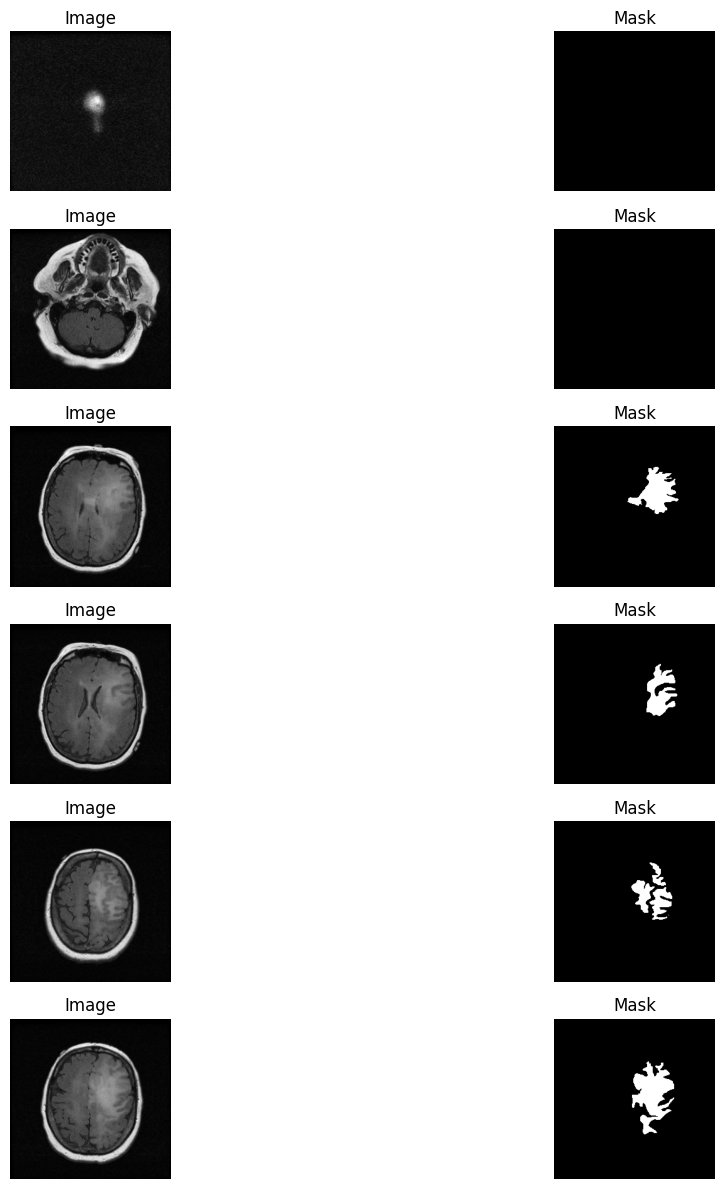

In [20]:
def plot_images(images, masks, num_images=6):

    plt.figure(figsize=(15, num_images * 2))  
    
    for i in range(num_images):
        plt.subplot(num_images, 2, 2 * i + 1) 
        plt.title('Image') 
        plt.imshow(images[i].squeeze(), cmap='gray') 
        plt.axis('off') 
        
        plt.subplot(num_images, 2, 2 * i + 2)  
        plt.title('Mask')  
        plt.imshow(masks[i].squeeze(), cmap='gray')  
        plt.axis('off')  
    
    plt.tight_layout()  
    plt.show()  

plot_images(images_array, masks_array, num_images=6)

In [9]:
train_images, test_images, train_masks, test_masks  = train_test_split(resized_images, resized_masks, test_size=0.2, random_state=42) # 60% train, 40% temp

In [10]:
def unet_model_functional(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Contracting path
    conv1 = Conv2D(28, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(28, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.3)(pool1)

    conv2 = Conv2D(26, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(26, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.3)(pool2)

    conv3 = Conv2D(26, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(26, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.3)(pool3)

    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.3)(pool4)

    # Bottleneck
    bottleneck = Conv2D(64, (3, 3), activation='relu', padding='same')(pool4)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Conv2D(64, (3, 3), activation='relu', padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Dropout(0.5)(bottleneck)

    # Expansive path
    up5 = UpSampling2D((2, 2))(bottleneck)
    up5 = concatenate([up5, conv4], axis=-1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Dropout(0.3)(conv5)

    up6 = UpSampling2D((2, 2))(conv5)
    up6 = concatenate([up6, conv3], axis=-1)
    conv6 = Conv2D(26, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(26, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(0.3)(conv6)

    up7 = UpSampling2D((2, 2))(conv6)
    up7 = concatenate([up7, conv2], axis=-1)
    conv7 = Conv2D(26, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(26, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(0.3)(conv7)

    up8 = UpSampling2D((2, 2))(conv7)
    up8 = concatenate([up8, conv1], axis=-1)
    conv8 = Conv2D(28, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(28, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Dropout(0.3)(conv8)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv8)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [14]:
model = unet_model_functional(input_size=(128, 128, 1))

In [15]:
train_masks = train_masks.reshape((-1, 128, 128, 1))
test_masks = test_masks.reshape((-1, 128, 128, 1))

In [16]:
model.compile(optimizer=Adam(learning_rate=1e-4),loss='binary_crossentropy',metrics=['accuracy'])
model.summary() 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │        280 │ input_layer_1[0]… │
│                     │ 28)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        112 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 28)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │      7,084 │ batch_normalizat… │
│                     │ 28)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        112 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 28)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 28)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_4[… │
│                     │ 28)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │      6,578 │ dropout_9[0][0]   │
│                     │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        104 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │      6,110 │ batch_normalizat… │
│                     │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        104 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 32, 32,    │          0 │ max_pooling2d_5[… │
│ (Dropout)           │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │      6,110 │ dropout_10[0][0]  │
│                     │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        104 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │      6,110 │ batch_normalizat… │
│                     │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        104 │ conv2d_24[0][0] 

 Total params: 202,457 (790.85 KB)

 Trainable params: 201,305 (786.35 KB)

 Non-trainable params: 1,152 (4.50 KB)

In [17]:
early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True, mode='max')

In [18]:
history = model.fit(train_images, train_masks, 
                    epochs=10, 
                    batch_size=16, 
                    validation_data=(test_images, test_masks),callbacks=[early_stopping])

Epoch 1/10


I0000 00:00:1754950014.301950     104 service.cc:148] XLA service 0x7fc1f0001930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754950014.303200     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754950014.303222     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754950016.216650     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/197 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.4917 - loss: 0.9458 

I0000 00:00:1754950031.839041     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


197/197 ━━━━━━━━━━━━━━━━━━━━ 62s 134ms/step - accuracy: 0.5130 - loss: 0.8241 - val_accuracy: 0.9664 - val_loss: 0.5318
Epoch 2/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.6293 - loss: 0.6629 - val_accuracy: 0.9709 - val_loss: 0.5466
Epoch 3/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.7714 - loss: 0.5763 - val_accuracy: 0.9845 - val_loss: 0.4830
Epoch 4/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8822 - loss: 0.5023 - val_accuracy: 0.9833 - val_loss: 0.4251
Epoch 5/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9430 - loss: 0.4297 - val_accuracy: 0.9815 - val_loss: 0.3642
Epoch 6/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.9715 - loss: 0.3624 - val_accuracy: 0.9871 - val_loss: 0.2986
Epoch 7/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.9837 - loss: 0.3014 - val_accuracy: 0.9823 - val_loss: 0.2586
Epoch 8/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9876 - loss: 0.2491 - val_accuracy: 0.9

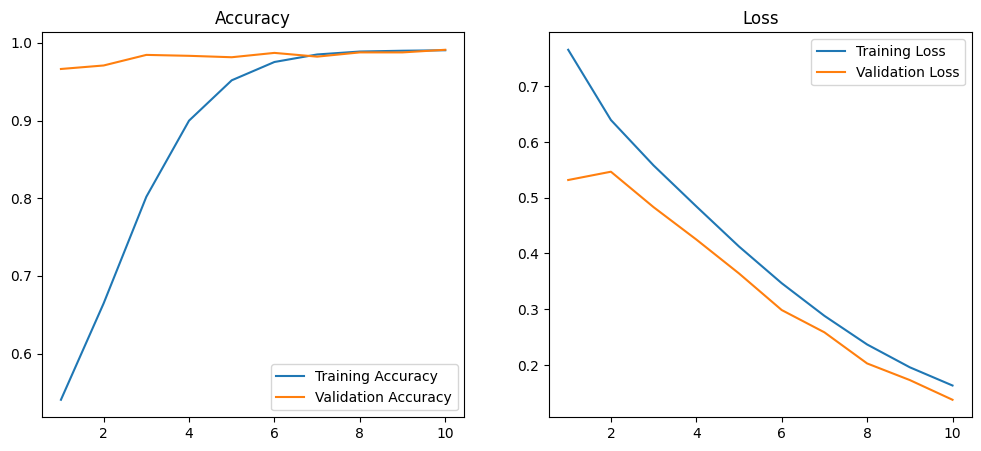

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [22]:
model.evaluate(train_images,train_masks, verbose= 1)

99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9911 - loss: 0.1379


[0.1369977742433548, 0.9915764927864075]

In [23]:
model.evaluate(test_images,test_masks, verbose= 1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9924 - loss: 0.1357


[0.13762864470481873, 0.9910916090011597]

In [24]:
y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step


In [137]:
def compare_masks(model, images, true_masks, num_samples=3):
    """
    مقارنة مفصلة بين الـ masks الحقيقية والمتوقعة
    """
    predicted_masks = model.predict(images[:num_samples])
    
    plt.figure(figsize=(12, num_samples * 2))
    
    for i in range(num_samples):
        # الصورة الأصلية
        plt.subplot(num_samples, 3, 3*i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'Image {i+1}')
        plt.axis('off')
        
        # الـ mask الحقيقي
        plt.subplot(num_samples, 3, 3*i + 2)
        plt.imshow(true_masks[i].squeeze(), cmap='Reds')
        plt.title('True Mask')
        plt.axis('off')
        
        # الـ mask المتوقع
      # ax = plt.subplot(num_samples, 3, 3*i + 3)
      # ax.set_facecolor('black')  # تغيير الخلفية للسواد
      # ax.imshow(predicted_masks[i].squeeze(), cmap='Blues')
      # ax.set_title('Predicted Mask', color='white')
      # ax.axis('off') 

        plt.subplot(num_samples, 3, 3*i + 3)
        plt.imshow(predicted_masks[i].squeeze(), cmap='Blues')
        plt.title('Predicted Mask')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


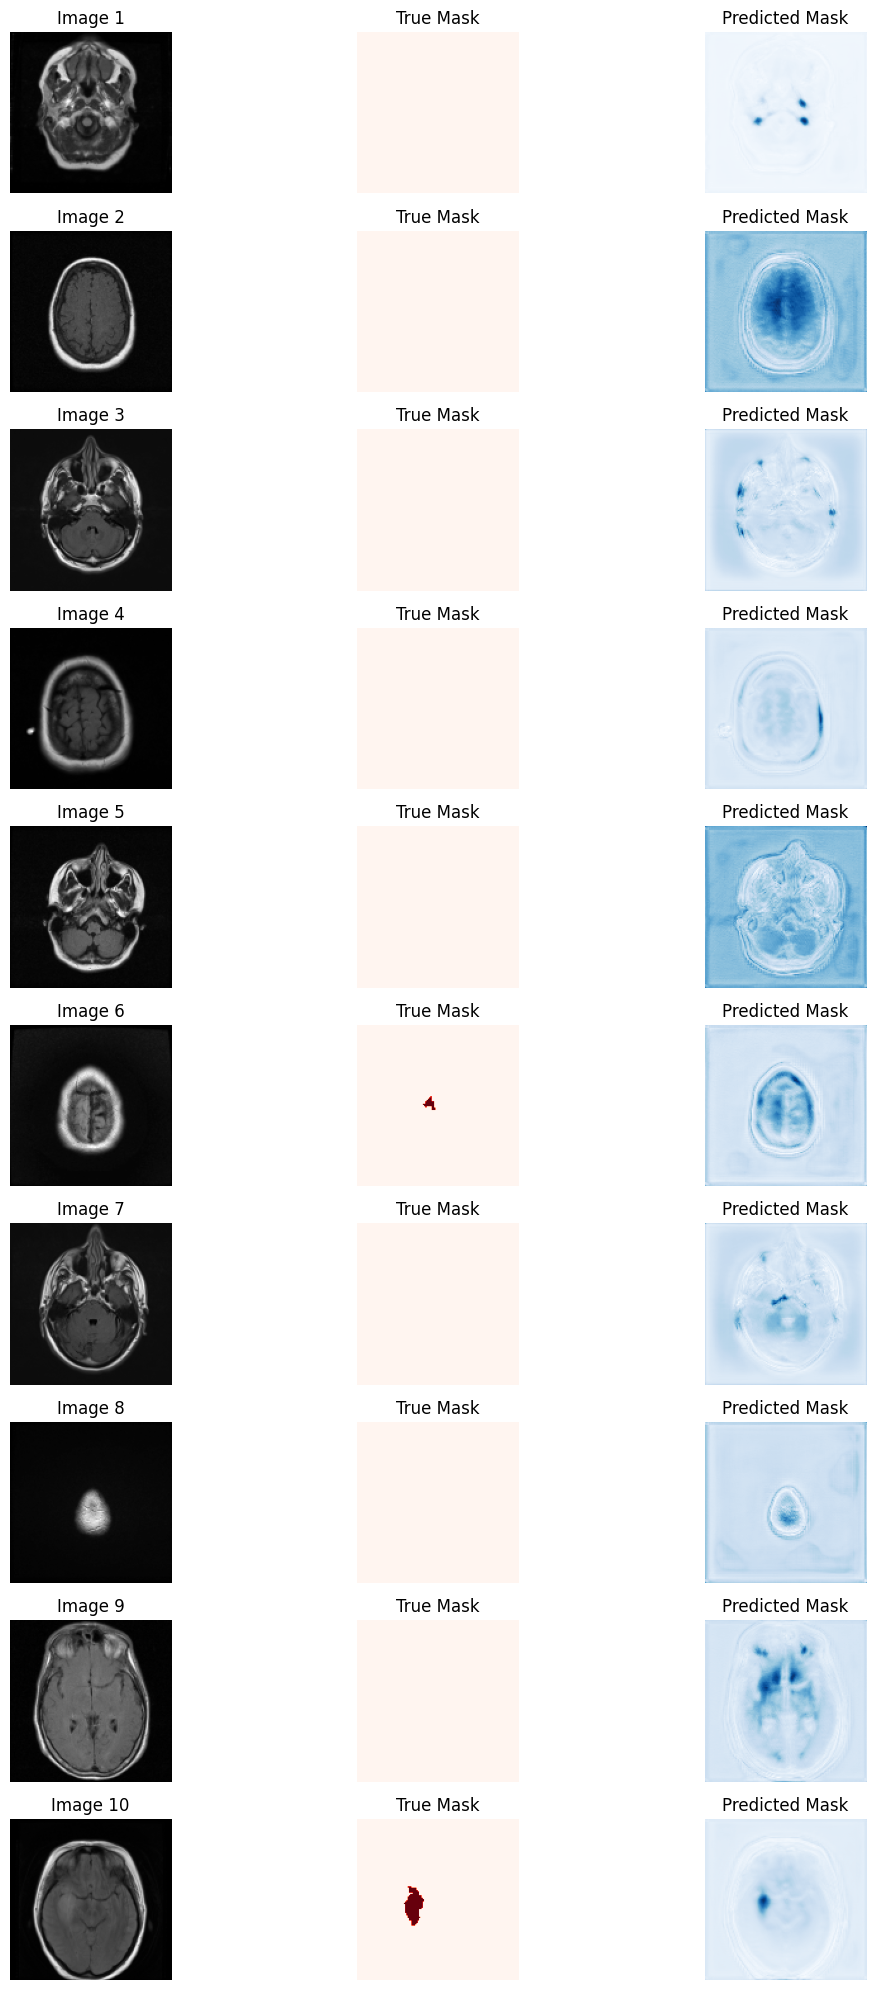

In [139]:
compare_masks(model, test_images, test_masks, num_samples=10)

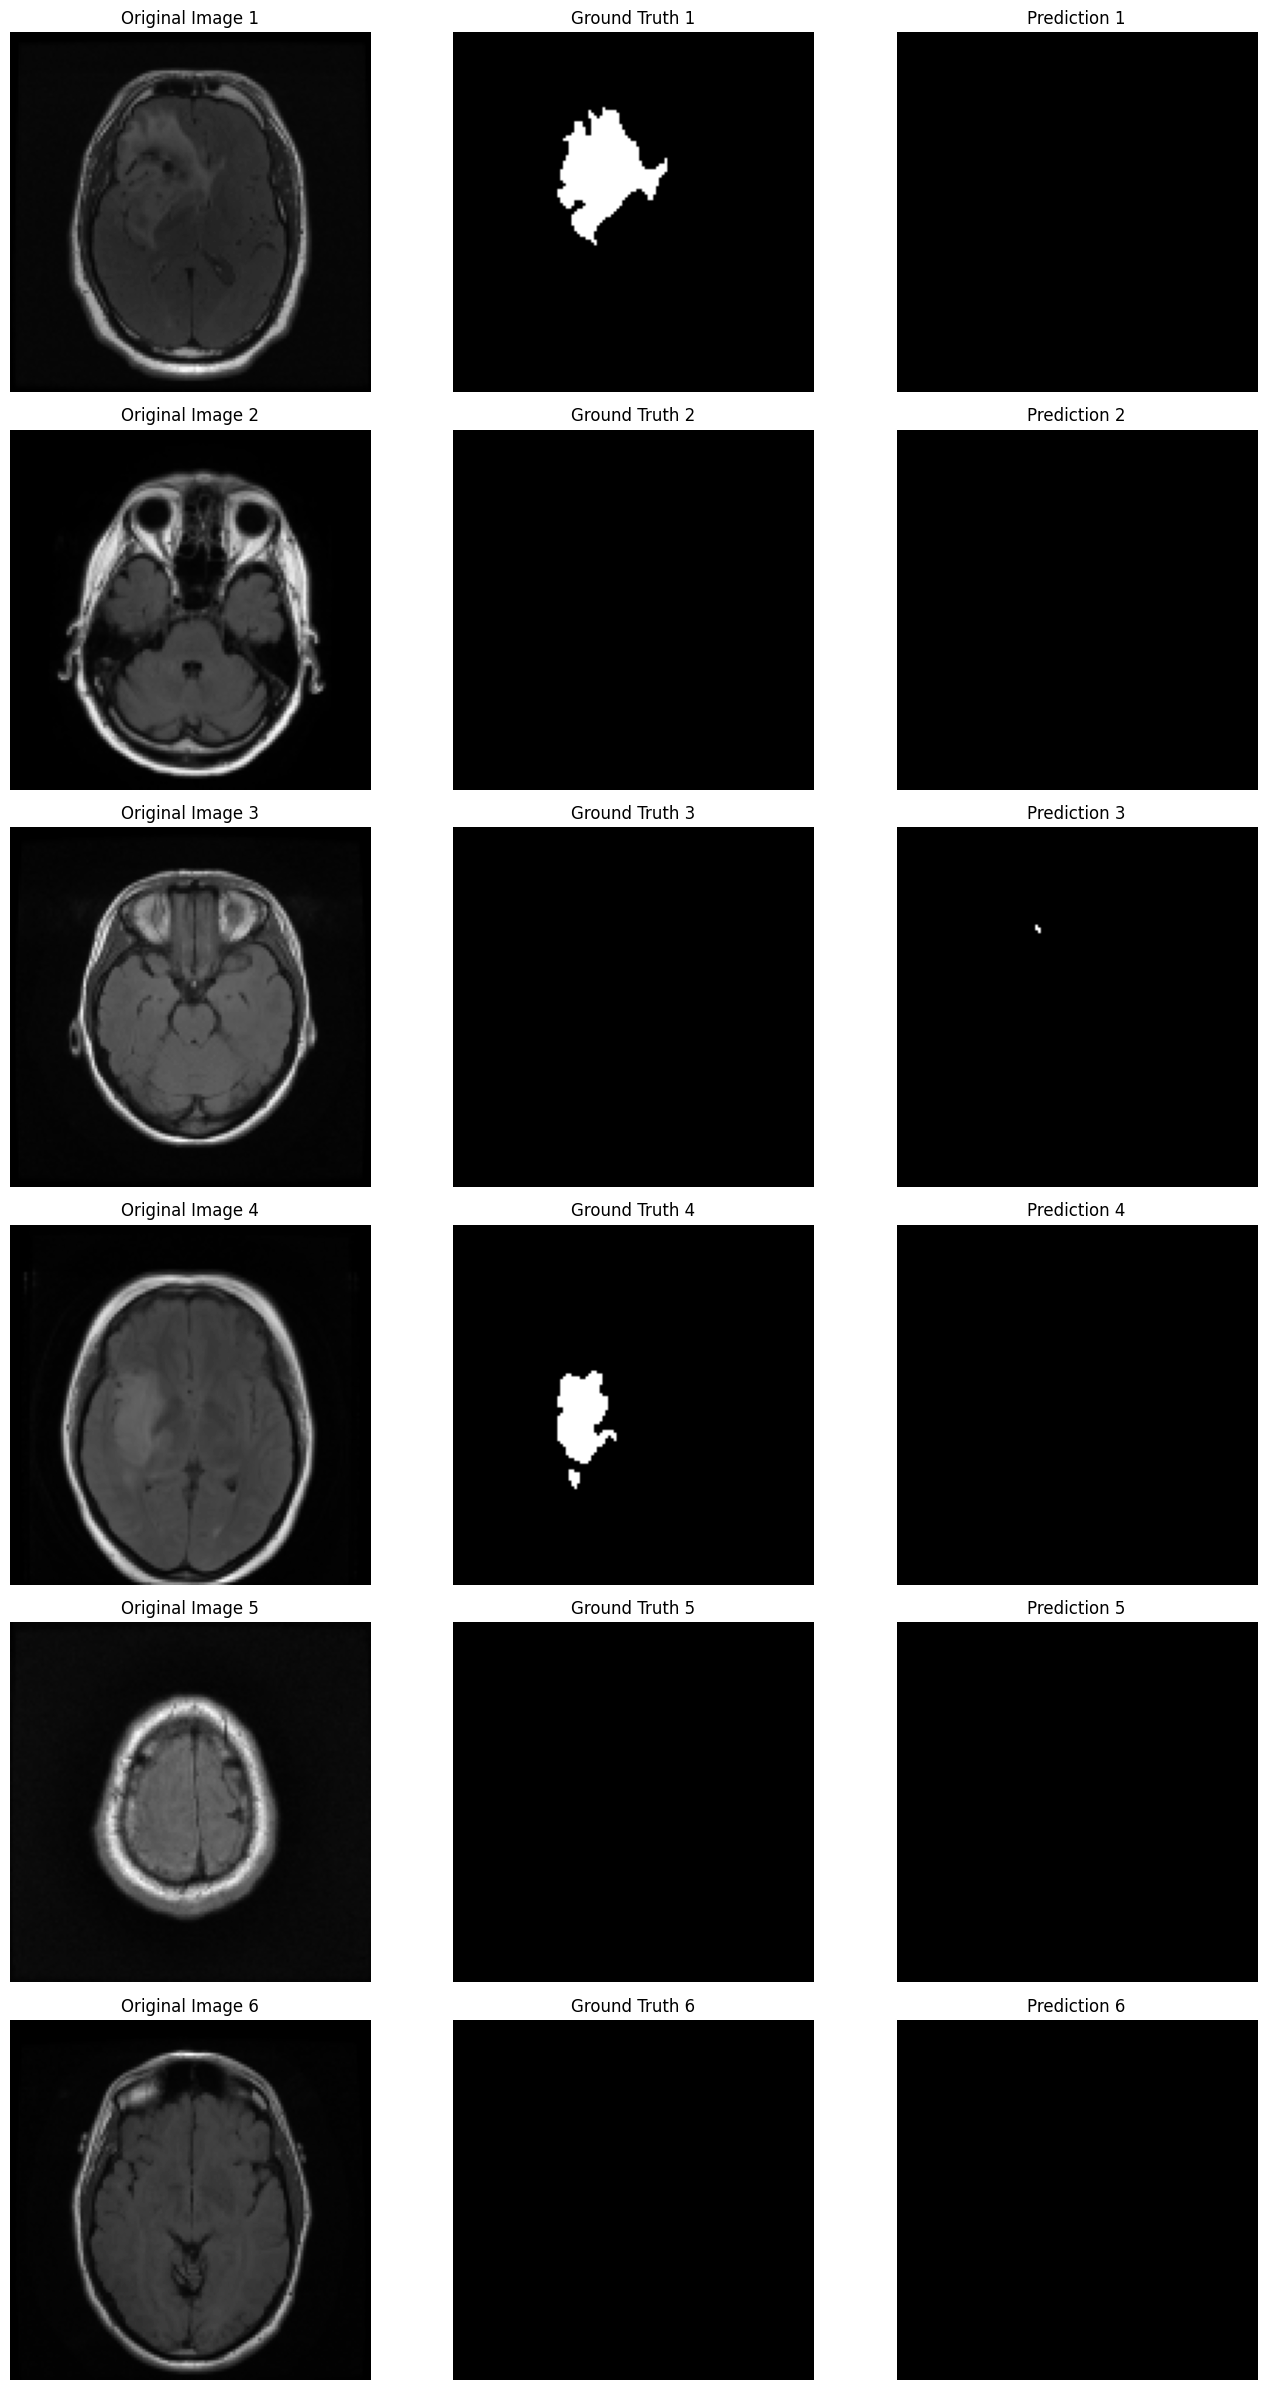

In [80]:
def visualize_predictions(model, images, masks, num_samples=6):
    fig, axes = plt.subplots(num_samples, 3, figsize=(14, 4*num_samples))

    for i in range(num_samples):
        idx = np.random.randint(0, len(images))  # اختيار صورة عشوائية

        image = images[idx]
        mask = masks[idx]

        # تجهيز الصورة للموديل
        img_input = np.expand_dims(image, axis=0)  # (1, H, W, 1)
        
        
        # التنبؤ
        prediction = model.predict(img_input, verbose=0)[0]
        pred_mask = (prediction > 0.5).astype(np.uint8)

        # عرض الصورة والنتائج
        axes[i, 0].imshow(image.squeeze(), cmap='gray')
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask.squeeze(), cmap='gray')
        axes[i, 1].set_title(f'Ground Truth {i+1}')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_mask.squeeze(), cmap='gray')
        axes[i, 2].set_title(f'Prediction {i+1}')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# الاستخدام:
visualize_predictions(model, resized_images, resized_masks, num_samples=6)


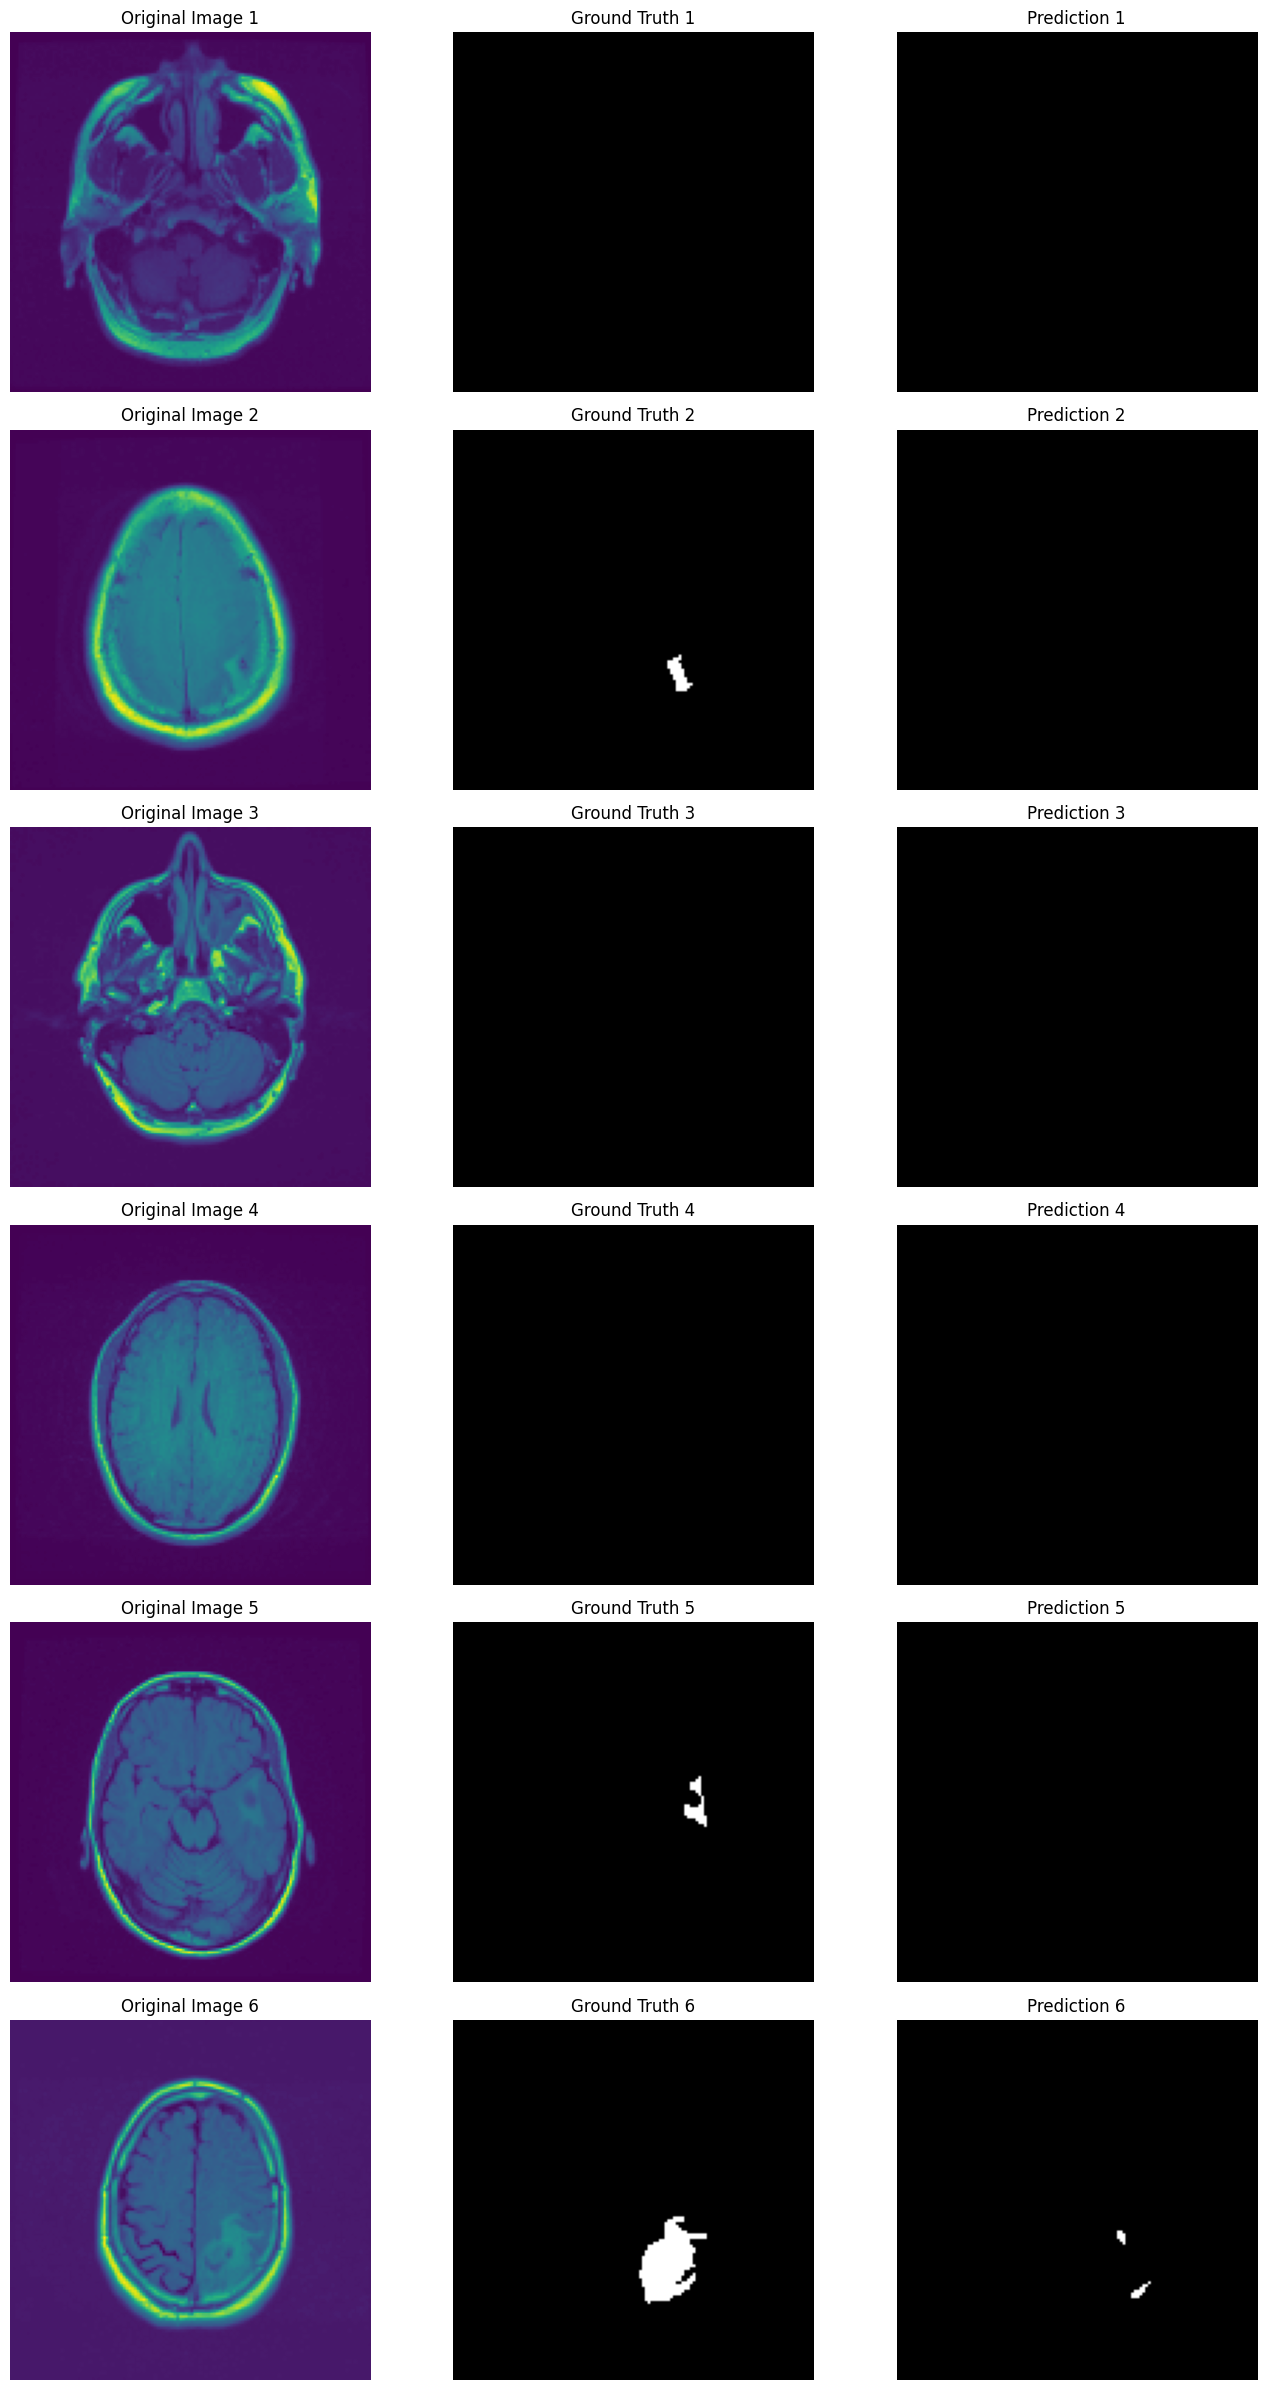

In [127]:
def visualize_predictions(model, images, masks, num_samples=6):
    fig, axes = plt.subplots(num_samples, 3, figsize=(14, 4*num_samples))

    for i in range(num_samples):
        idx = np.random.randint(0, len(images))  

        image = images[idx]
        mask = masks[idx]

        # تجهيز الصورة للموديل (إضافة batch dimension)
        img_input = np.expand_dims(image, axis=0)  # (1, H, W, 1)

        # التنبؤ
        prediction = model.predict(img_input, verbose=0)[0]
        pred_mask = (prediction > 0.5).astype(np.uint8)

        # إذا الصورة grayscale نحولها لـ RGB للعرض الملون
        if image.shape[-1] == 1:
            display_image = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
        else:
            display_image = (image * 255).astype(np.uint8)

        # عرض الصورة والنتائج
        axes[i, 0].imshow(display_image)
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask.squeeze(), cmap='gray')
        axes[i, 1].set_title(f'Ground Truth {i+1}')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_mask.squeeze(), cmap='gray')
        axes[i, 2].set_title(f'Prediction {i+1}')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


# الاستخدام
visualize_predictions(model, resized_images, resized_masks, num_samples=6)


In [140]:
model.save('Brain Tumors in CNN_whit_Pre-Trained_model_Segmentation use U_Net.h5')

In [ ]:
# /kaggle/working/Brain Tumors in CNN_whit_Pre-Trained_model_Segmentation use U_Net.h5